# Hierarchical DivNoising - Prediction
This notebook contains an example on how to use a previously trained Hierarchical DivNoising model to denoise images.
If you haven't done so please first run '1-CreateNoiseModel.ipynb' and '2-Training.ipynb' notebooks.

In [1]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.cuda.amp import autocast

import sys
sys.path.insert(0, '/home/igor.zubarev/projects/HDN-main/')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load noisy test data
The GT test data (```signal```) is created by averaging the noisy images (```observations```).

In [ ]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

link = 'https://download.fht.org/jug/denoiseg/Mouse-Organoid-Cells-CBG-128_n20.zip'

# check if data has been downloaded already
zipPath = 'data/Mouse-Organoid-Cells-CBG-128_n20.zip'
if not os.path.exists(zipPath):
    data = urllib.request.urlretrieve(link, zipPath)

#unzip the files
if not os.path.exists(zipPath[:-4]):
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')

In [ ]:
val = np.load(os.path.join(zipPath[:-8], 'test_data_n20.npz'))
observation = val['X_test'].astype(np.float32)

print("Shape of Validation mask:   {}".format(observation.shape))

In [ ]:
path = '/home/igor.zubarev/projects/HDN-main/examples/3D/Pixel_Noise/data/Mouse-Organoid-Cells-CBG-128/'
val = np.load(path + 'test_data_n20.npz')
observation = val['X_test']
print(observation.shape)

# 3D visualization(optional)

In [ ]:
# Install visualisation tools
!{sys.executable} -m pip install itkwidgets

In [3]:
from itkwidgets import view, compare

# view(observation[0])

In [4]:
observation = imread('/home/igor.zubarev/data/aics/AICS-12_882_2.tif').astype(np.float32)[np.newaxis, ...]
print(observation.shape)

(1, 49, 624, 924)


In [5]:
view(observation.squeeze())

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [ ]:
# observation = sw[2490:]
signal = observation
# signal=np.mean(observation[:,...],axis=0)[np.newaxis,...]
print("Shape of validation image:", observation.shape)

# Load our model

In [6]:
%%capture
model = torch.load("./Trained_model/model/aics_m_gc_last_vae.net")
model.mode_pred=True
model.eval()

# Compute PSNR
The higher the PSNR, the better the denoising performance is.
PSNR is computed using the formula: 

```PSNR = 20 * log(rangePSNR) - 10 * log(mse)``` <br> 
where ```mse = mean((gt - img)**2)```, ```gt``` is ground truth image and ```img``` is the prediction from HDN. All logarithms are with base 10.<br>
rangePSNR = max(```gt```)-min(```gt```) for as used in this [paper](https://ieeexplore.ieee.org/abstract/document/9098612/).

In [ ]:
gaussian_noise_std = None
num_samples = 10 # number of samples used to compute MMSE estimate
tta = False # turn on test time augmentation when set to True. It may improve performance at the expense of 8x longer prediction time
predicted = []
psnrs = []
range_psnr = np.max(signal[0])-np.min(signal[0])
for i in range(observation.shape[0]):
    img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
    psnr = utils.PSNR(signal[0], img_mmse, range_psnr)
    predicted.append(img_mmse)
    psnrs.append(psnr)
    print("image:", i, 'img_shape:', observation[i].shape, "PSNR:", psnr, "Mean PSNR:", np.mean(psnrs))

In [12]:
zps = 49
ps = 256
z_overlap = 0
overlap = 48
num_samples = 1
tta = False
gaussian_noise_std = None
im = observation[0]
assert zps <= im.shape[0]
assert zps > z_overlap

zmin = 0
ymin = 0
xmin = 0
zmax = zps
ymax = ps
xmax = ps
pred = np.zeros(im.shape)

tiles = []
crops = []
coords = []

ovZ = 0
while zmin < im.shape[0]:
    ovLeft=0
    while (xmin<im.shape[1]):
        ovTop=0
        while (ymin<im.shape[2]):
            zmin_ = min(im.shape[0], zmax) - zps
            ymin_ = min(im.shape[1], ymax) - ps
            xmin_ = min(im.shape[2], xmax) - ps
            lastPatchShiftZ = zmin - zmin_
            lastPatchShiftY = ymin - ymin_
            lastPatchShiftX = xmin - xmin_  
            print('C', zmin_, zmax, ymin_, ymax, xmin_, xmax)
            print('O', lastPatchShiftZ, lastPatchShiftY, lastPatchShiftX,  ovZ, ovLeft, ovTop)
            if ((zmin_, ymin_, ymax), (zmin_, xmin_, xmax)) not in coords:
                coords.append(((zmin_, ymin_, ymax), (zmin_, xmin_, xmax)))
                img_mmse, samples = boilerplate.predict(im[zmin_:zmax, ymin_:ymax, xmin_:xmax], 
                                                        num_samples,
                                                        model,
                                                        gaussian_noise_std,
                                                        device,
                                                        tta)
                print(im[zmin_:zmax, ymin_:ymax, xmin_:xmax].shape,
                    img_mmse[lastPatchShiftZ:, lastPatchShiftY:, lastPatchShiftX:][ovZ:, ovTop:, ovLeft:].shape)
                tiles.append(im[zmin_:zmax, ymin_:ymax, xmin_:xmax])
                crops.append(img_mmse[lastPatchShiftZ:, lastPatchShiftY:, lastPatchShiftX:][ovZ:, ovTop:, ovLeft:])
                pred[zmin:zmax, ymin:ymax, xmin:xmax][ovZ:, ovTop:, ovLeft:] = img_mmse[lastPatchShiftZ:, lastPatchShiftY:, lastPatchShiftX:][ovZ:, ovTop:, ovLeft:]
            ymin=ymin-overlap+ps
            ymax=ymin+ps
            ovTop=overlap//2
        ymin=0
        ymax=ps
        xmin=xmin-overlap+ps
        xmax=xmin+ps
        ovLeft=overlap//2
    xmin = 0
    xmax = ps
    zmin = zmin - z_overlap + zps
    zmax = zmin + zps
    ovZ = z_overlap//2
    print('Z', zmin)

tiles = np.stack(tiles)
crops = [crop for crop in crops if all(crop.shape) > 0]
print(tiles.shape, len(crops))



C 0 49 0 256 0 256
O 0 0 0 0 0 0
(49, 256, 256) (49, 256, 256)
C 0 49 208 464 0 256
O 0 0 0 0 0 24
(49, 256, 256) (49, 232, 256)
C 0 49 368 672 0 256
O 0 48 0 0 0 24
(49, 256, 256) (49, 184, 256)
C 0 49 368 880 0 256
O 0 256 0 0 0 24
(49, 256, 256) (49, 0, 256)
C 0 49 368 1088 0 256
O 0 464 0 0 0 24
(49, 256, 256) (49, 0, 256)
C 0 49 0 256 208 464
O 0 0 0 0 24 0
(49, 256, 256) (49, 256, 232)
C 0 49 208 464 208 464
O 0 0 0 0 24 24
(49, 256, 256) (49, 232, 232)
C 0 49 368 672 208 464
O 0 48 0 0 24 24
(49, 256, 256) (49, 184, 232)
C 0 49 368 880 208 464
O 0 256 0 0 24 24
(49, 256, 256) (49, 0, 232)
C 0 49 368 1088 208 464
O 0 464 0 0 24 24
(49, 256, 256) (49, 0, 232)
C 0 49 0 256 416 672
O 0 0 0 0 24 0
(49, 256, 256) (49, 256, 232)
C 0 49 208 464 416 672
O 0 0 0 0 24 24
(49, 256, 256) (49, 232, 232)
C 0 49 368 672 416 672
O 0 48 0 0 24 24
(49, 256, 256) (49, 184, 232)
C 0 49 368 880 416 672
O 0 256 0 0 24 24
(49, 256, 256) (49, 0, 232)
C 0 49 368 1088 416 672
O 0 464 0 0 24 24
(49, 256, 2

In [ ]:
print(pred.shape)

3


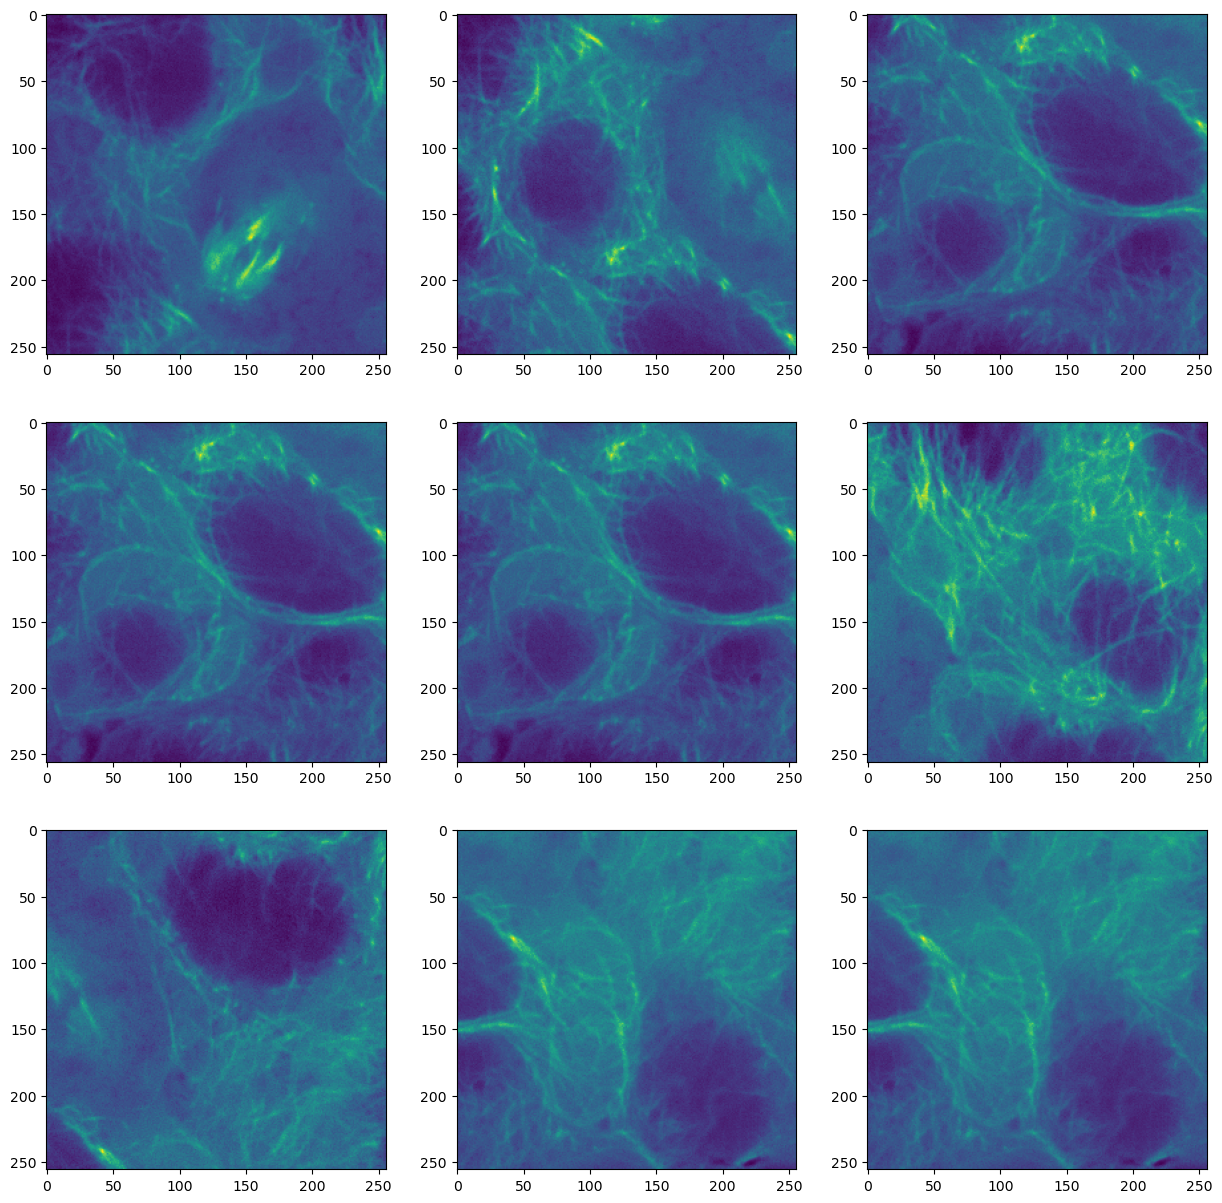

In [8]:
size = int(np.floor(np.sqrt(tiles.shape[0])))
print(size)

_, ax = plt.subplots(nrows=size, ncols=size, figsize=(15, 15))
n = 0
for i in range(size):
    for j in range(size):
        ax[i][j].imshow(tiles[n][10])
        n+=1

plt.show()

(49, 256, 256)
(49, 232, 256)
(49, 184, 256)
(49, 256, 232)
(49, 232, 232)
(49, 184, 232)
(49, 256, 232)
(49, 232, 232)
(49, 184, 232)


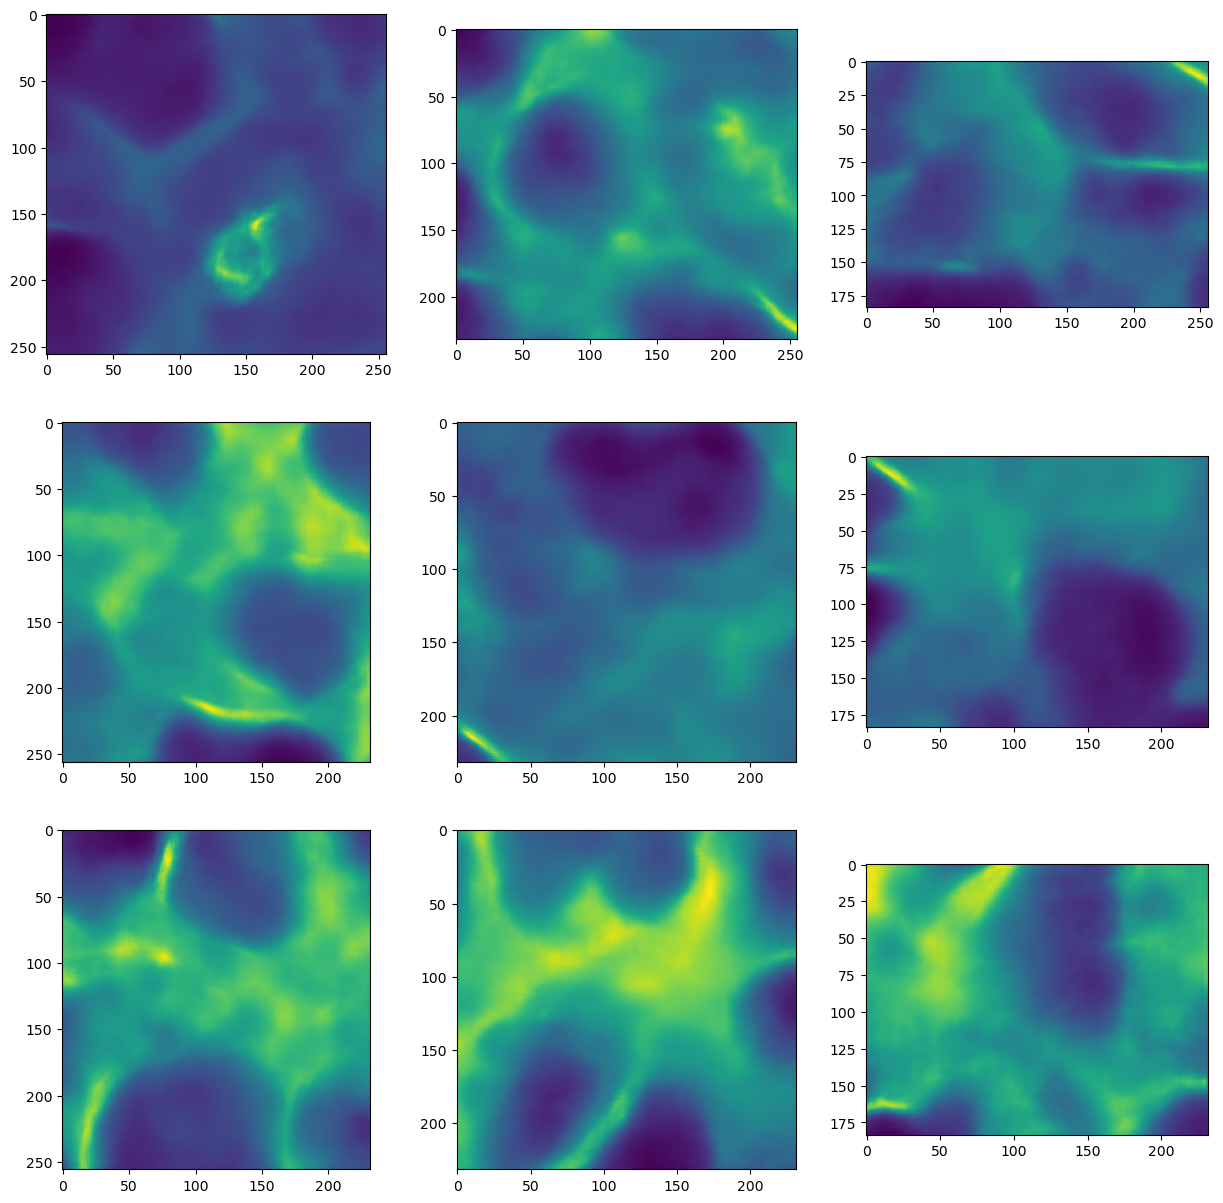

In [13]:
size = int(np.floor(np.sqrt(len(crops))))

for crop in crops:
    print(crop.shape)
    
_, ax = plt.subplots(nrows=size, ncols=size, figsize=(15, 15))
n = 0
for i in range(size):
    for j in range(size):
        ax[i][j].imshow(crops[n][10])
        n+=1

plt.show()

In [10]:
view(pred)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

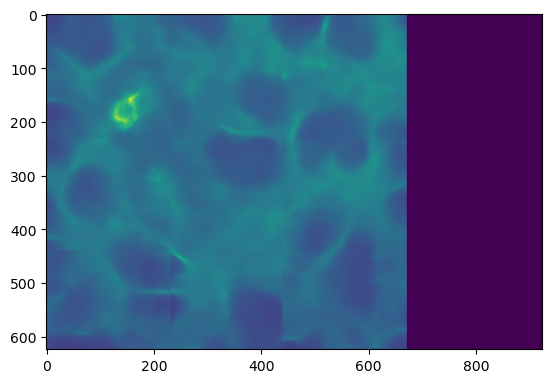

In [14]:
plt.imshow(pred[10, ...])
plt.show()

# Here we look at some qualitative solutions

In [ ]:
predicted_images = np.stack(predicted)
print(observation.shape, predicted_images.shape)

In [ ]:
image_number = 6
slice_number = 20
fig=plt.figure(figsize=(20, 10))
gt = signal[0][slice_number, :128,:128]
vmin=np.percentile(gt,0)
vmax=np.percentile(gt,99)

columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(observation[image_number][slice_number, :128, :128],cmap='magma')
plt.title("Raw")
fig.add_subplot(rows, columns, 2)
plt.imshow(gt, vmin=vmin, vmax=vmax,cmap='magma')
plt.title("GT")
fig.add_subplot(rows, columns, 3)
plt.imshow(predicted_images[image_number][slice_number, :128, :128],vmin=vmin, vmax=vmax,cmap='magma')
plt.title("MMSE")
for i in range(4, columns*rows+1):
    img = samples[i][slice_number, :128, :128]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, vmin=vmin, vmax=vmax, cmap='magma')
    plt.title("Sample "+str(i-4))
plt.show()

In [ ]:
compare(observation[0], predicted_images[0])

In [ ]:
view(observation[0])

In [ ]:
view(predicted_images[0])

In [ ]:
def imagetopatches(x):
    